<a href="https://colab.research.google.com/github/ccj5351/studynotes/blob/master/loading_pytorch_to_tensorflow_float32_vs_float64_precision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Pytorch model to Tensorflow by Hand

> see the references that helped me when solving this task.
>  - [Manualy convert pytorch weights to tf.keras weights for convolutional layer](https://stackoverflow.com/questions/68165375/manualy-convert-pytorch-weights-to-tf-keras-weights-for-convolutional-layer)
>  - [Pytorch convolution and tensorflow convolution giving different results](https://discuss.pytorch.org/t/pytorch-convolution-and-tensorflow-convolution-giving-different-results/26863)
>  - [A single conv and same input leads to results different from tensorflow](https://discuss.pytorch.org/t/a-single-conv-and-same-input-leads-to-results-different-from-tensorflow/17735/2)
>  - [How to set weights in Keras with a numpy array?](https://stackoverflow.com/questions/47183159/how-to-set-weights-in-keras-with-a-numpy-array)
>  - [Copying weight tensors from PyTorch to Tensorflow (and back)](https://www.adrian.idv.hk/2022-05-21-torch2tf/)
>  - [Converting a Simple Deep Learning Model from PyTorch to TensorFlow](https://towardsdatascience.com/converting-a-simple-deep-learning-model-from-pytorch-to-tensorflow-b6b353351f5d)

In this tutorial we will load the pretrained PyTorch (PT) model weights to the TensorFlow (TF) model by hand.

### Take-home message:
- [x]: batch input dimension in TensorFlow: NHWC, PyTorch: NCHW, and convolution weights in TF: [H, W, C$_i$, C$_o$], PyTorch [C$_o$, C$_i$, H, W]; So when assign PyTorch weights to TF, you have to transpose the weights accordingly.
- [x]: `float32` vs `float64`. Even if you have already assigned the weights correctly from PT to TF, probably the their resutls are different due to floa

In [1]:
import tensorflow as tf

## Feature Module - TensorFlow Code

In [2]:
import tensorflow as tf
import pdb
from tensorflow.keras import layers, models

class FeatureExtractor(tf.keras.layers.Layer):
    """Feature extraction
    Args:
        C: list of number of feature channels, C=[C0,C1,C2,C3,C4],
        e.g., C=[16,16,24,24,32];
    Returns: a list of features at different resolutions, including:
        o4: tensor in shape of [B,C0,H,W]
        o3: tensor in shape of [B,C1,H/2,W/2]
        o2: tensor in shape of [B,C2,H/4,W/4]
        o1: tensor in shape of [B,C3,H/8,W/8]
        o0: tensor in shape of [B,C4,H/16,W/16]
    """
    def __init__(self, C):
        super().__init__()
        assert len(C) in [5], f"Have {len(C)} scales of features"
        #self.down_0 = models.Sequential([
        #    layers.Conv2D(
        #        C[0], #output_planes
        #        kernel_size=3,
        #        strides=1,
        #        padding='same',
        #        use_bias=True
        #        ),
        #    layers.LeakyReLU(alpha=0.2)
        #    ])

        self.down_0 = layers.Conv2D(
                C[0], #output_planes
                kernel_size=3,
                strides=1,
                padding='same',
                use_bias=True
                )

        self.down_1 = models.Sequential([
            layers.Conv2D(C[1], kernel_size=4, strides=2, padding='same'),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(C[1], kernel_size=3, strides=1, padding='same'),
            layers.LeakyReLU(alpha=0.2)
        ])

        self.down_2 = models.Sequential([
            layers.Conv2D(C[2], kernel_size=4, strides=2, padding='same'),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(C[2], kernel_size=3, strides=1, padding='same'),
            layers.LeakyReLU(alpha=0.2)
        ])

        self.down_3 = models.Sequential([
            layers.Conv2D(C[3], kernel_size=4, strides=2, padding='same'),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(C[3], kernel_size=3, strides=1, padding='same'),
            layers.LeakyReLU(alpha=0.2)
        ])

        self.down_4 = models.Sequential([
            layers.Conv2D(C[4], kernel_size=4, strides=2, padding='same'),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(C[4], kernel_size=3, strides=1, padding='same'),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(C[4], kernel_size=3, strides=1, padding='same'),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(C[4], kernel_size=3, strides=1, padding='same'),
            layers.LeakyReLU(alpha=0.2)
        ])

        self.up_3 = UpsampleBlock(C[4], C[3])
        self.up_2 = UpsampleBlock(C[3], C[2])
        self.up_1 = UpsampleBlock(C[2], C[1])
        self.up_0 = UpsampleBlock(C[1], C[0])

    def call(self, input):
        x0 = self.down_0(input) # [B,H,W,C0]
        print (f"tf x0 shape = {x0.shape}, some values = {x0[0,:5,:5,0]}")
        x1 = self.down_1(x0) # [B,H/2,W/2,C1]
        x2 = self.down_2(x1) # [B,H/4,W/4,C2]
        x3 = self.down_3(x2) # [B,H/8,W/8,C3]
        o0 = self.down_4(x3) # [B,H/16,W/16,C4]

        o1 = self.up_3(o0, x3) #[B,H/8,W/8,C3]
        o2 = self.up_2(o1, x2) #[B,H/4,W/4,C2]
        o3 = self.up_1(o2, x1) #[B,H/2,W/2,C1]
        o4 = self.up_0(o3, x0) #[B,H,W,C0]
        #pdb.set_trace()
        #return o4, o3, o2, o1, o0
        res = {
            'x0': x0,
            'x1': x1,
            'x2': x2,
            'x3': x3,
            'o0': o0,
            'o1': o1,
            'o2': o2,
            'o3': o3,
            'o4': o4,
        }
        return res

class UpsampleBlock(layers.Layer):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.c0 = in_channels
        c1 = out_channels
        #self.up_conv = models.Sequential([
        self.up_conv = tf.keras.Sequential([
            layers.Conv2DTranspose(c1, kernel_size=2, strides=2, padding='same'),
            layers.LeakyReLU(alpha=0.2)
        ])

        #self.merge_conv = models.Sequential([
        self.merge_conv = tf.keras.Sequential([
            layers.Conv2D(c1, kernel_size=1, padding='valid', data_format='channels_last'),
            layers.LeakyReLU(alpha=0.2),

            layers.Conv2D(c1, kernel_size=3, strides=1, padding='same'),
            layers.LeakyReLU(alpha=0.2),

            layers.Conv2D(c1, kernel_size=3, strides=1, padding='same'),
            layers.LeakyReLU(alpha=0.2)
        ])

    def call(self, input, skip):
        print (input.shape, self.c0)
        #assert input.shape[-1] == self.c0, "Wrong channels dimensionality"
        x = self.up_conv(input)
        x = tf.concat([x, skip], axis=-1) # channels_last
        x = self.merge_conv(x)
        return x

## Feature Module - PyTorch Code

In [3]:
import torch
import torch.nn as nn

class FeatureExtractor_PT(nn.Module):
    def __init__(self, C):
        """Feature extraction
        Args:
            C: list of number of feature channels, C=[C0,C1,C2,C3,C4],
               e.g., C=[16,16,24,24,32];
        Returns: a list of features at different resolutions, including:
            o4: tensor in shape of [B,C0,H,W]
            o3: tensor in shape of [B,C1,H/2,W/2]
            o2: tensor in shape of [B,C2,H/4,W/4]
            o1: tensor in shape of [B,C3,H/8,W/8]
            o0: tensor in shape of [B,C4,H/16,W/16]
        """
        super().__init__()
        assert len(C) in [5], f"Have {len(C)} scales of features"
        #self.down_0 = nn.Sequential(
        #    nn.Conv2d(3, C[0], kernel_size=3, stride=1, padding=1,
        #            bias=True # by default;
        #            ),
        #    nn.LeakyReLU(0.2),
        #)
        self.down_0 = nn.Conv2d(3, C[0], kernel_size=3, stride=1, padding=1,
                    bias=True # by default;
                    )

        self.down_1 = nn.Sequential(
            #SameConv2d(C[0], C[1], kernel_size=4, stride=2),
            nn.Conv2d(C[0], C[1], kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(C[1], C[1], kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
        )
        self.down_2 = nn.Sequential(
            #SameConv2d(C[1], C[2], 4, 2),
            nn.Conv2d(C[1], C[2], kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(C[2], C[2], kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
        )
        self.down_3 = nn.Sequential(
            #SameConv2d(C[2], C[3], 4, 2),
            nn.Conv2d(C[2], C[3], kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(C[3], C[3], kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
        )
        self.down_4 = nn.Sequential(
            #SameConv2d(C[3], C[4], 4, 2),
            nn.Conv2d(C[3], C[4], kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(C[4], C[4], kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(C[4], C[4], kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(C[4], C[4], kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
        )
        self.up_3 = UpsampleBlock_PT(C[4], C[3])
        self.up_2 = UpsampleBlock_PT(C[3], C[2])
        self.up_1 = UpsampleBlock_PT(C[2], C[1])
        self.up_0 = UpsampleBlock_PT(C[1], C[0])

    def forward(self, input):
        x0 = self.down_0(input) # [B,C0,H,W]
        print (f"Pytorch x0 shape = {x0.shape}, some values = {x0[0,0, :5,:5]}")
        x1 = self.down_1(x0) # [B,C1,H/2,W/2]
        x2 = self.down_2(x1) # [B,C2,H/4,W/4]
        x3 = self.down_3(x2) # [B,C3,H/8,W/8]
        o0 = self.down_4(x3) # [B,C4,H/16,W/16]

        o1 = self.up_3(o0, x3) #[B,C3,H/8,W/8]
        o2 = self.up_2(o1, x2) #[B,C2,H/4,W/4]
        o3 = self.up_1(o2, x1) #[B,C1,H/2,W/2]
        o4 = self.up_0(o3, x0) #[B,C0,H,W]
        #pdb.set_trace()
        #return o4, o3, o2, o1, o0
        res = {
            'x0': x0,
            'x1': x1,
            'x2': x2,
            'x3': x3,
            'o0': o0,
            'o1': o1,
            'o2': o2,
            'o3': o3,
            'o4': o4,
        }
        return res

class UpsampleBlock_PT(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        c0 = in_channels
        c1 = out_channels
        self.up_conv = nn.Sequential(
            nn.ConvTranspose2d(c0, c1, kernel_size=2, stride=2),
            nn.LeakyReLU(negative_slope=0.2),
        )
        self.merge_conv = nn.Sequential(
            nn.Conv2d(c1 * 2, c1, kernel_size=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
        )

    def forward(self, input, skip):
        x = self.up_conv(input)
        ## should be in the same resolution now
        #if x.size()[2:] != skip.size()[2:]:
        #    x = x[:, :, : skip.size(2), : skip.size(3)]
        x = torch.cat((x, skip), dim=1)
        x = self.merge_conv(x)
        return x

## Input and Set Floating Point Precision

- Set the float type in TensorFlow via `tf.keras.backend.set_floatx('float64')` or `tf.keras.backend.set_floatx('float32')`.

- Set the float type in PyTorch via `torch.set_default_dtype(torch.float64)` or `torch.set_default_dtype(torch.float32)`.

In [4]:
import numpy as np
np.random.seed(88883)
num_feature = [16, 16, 24, 24, 32]

USING_FLOAT64 = True

if USING_FLOAT64:
  tf.keras.backend.set_floatx('float64')
  torch.set_default_dtype(torch.float64)
  DATA_TYPE = np.float64
else:
  tf.keras.backend.set_floatx('float32')
  torch.set_default_dtype(torch.float32)
  DATA_TYPE = np.float32

height = 128
width = 256

#prepare inputs and do inference
x = np.random.rand(1, 3, height, width).astype(DATA_TYPE)
x_tf = np.transpose(x, (0, 2, 3, 1)).astype(DATA_TYPE)

Create an instance of the feature extractor in TensorFlow first.

In [5]:
feature_extractor = FeatureExtractor(num_feature)
lf = feature_extractor(x_tf)

tf x0 shape = (1, 128, 256, 16), some values = [[-0.11584787 -0.15231569 -0.2665561  -0.15198092 -0.22057036]
 [-0.28681828 -0.5179587  -0.41952042 -0.3106658  -0.36161061]
 [-0.06758231 -0.3103331  -0.39738146 -0.35538858 -0.4615705 ]
 [-0.1607221  -0.30408457 -0.64614803 -0.09946881 -0.55594852]
 [-0.08477888 -0.36469683 -0.36448385 -0.3245575  -0.33466563]]
(1, 8, 16, 32) 32
(1, 16, 32, 24) 24
(1, 32, 64, 24) 24
(1, 64, 128, 16) 16


Then create another instance of the feature extractor in Pytorch.

In [6]:
torch.set_printoptions(precision=8)
feature_extractor_pt = FeatureExtractor_PT(num_feature)

If you want to specify the weights of first convolution layer by hand, do the following assignment.

In [7]:
RESET_LAYER_ZERO = True
if RESET_LAYER_ZERO:
  out_plane = num_feature[0]
  in_plane = 3
  k = 3
  torch_weights = np.random.rand(out_plane, in_plane, k, k).astype(DATA_TYPE)
  bias = np.random.rand(out_plane).astype(DATA_TYPE)
  tf_weights = np.transpose(torch_weights, (2, 3, 1, 0)).astype(DATA_TYPE)

  conv0 = getattr(feature_extractor_pt, 'down_0')
  conv0.weight = torch.nn.Parameter(torch.from_numpy(torch_weights))
  conv0.bias = torch.nn.Parameter(torch.from_numpy(bias))

In [8]:
x_pt = torch.from_numpy(x)
print ("PyTorch ...")
lf_pt = feature_extractor_pt(x_pt)
print (conv0.weight.dtype, conv0.bias.dtype)

PyTorch ...
Pytorch x0 shape = torch.Size([1, 16, 128, 256]), some values = tensor([[3.91926824, 5.81627401, 5.01474286, 4.82458783, 5.29005626],
        [6.21916518, 7.65551395, 7.66813092, 6.18409405, 6.82858778],
        [5.76677646, 7.06619377, 7.27656830, 6.16707753, 7.14074652],
        [4.88346984, 6.88705355, 6.03917426, 8.72257558, 7.32111244],
        [5.58896538, 7.20987216, 7.36217130, 7.87393225, 8.03545963]],
       grad_fn=<SliceBackward0>)
torch.float64 torch.float64


To load pytorch weights to Tensorflow. We can save Pytorch checkpoint to a json file for TensorFlow model to load later.

In [19]:
# load pytorch weights to Tensorflow
# save Pytorch checkpoint to json for TensorFlow model to load;
import json

#Start by connecting gdrive into the google colab
from google.colab import drive
drive.mount('/content/drive')
# Now your Google Drive is mounted to this location /content/gdrive/My Drive/
#!ls "/content/drive/My Drive/"

ckpt = feature_extractor_pt.state_dict()
n = 0
to_save = {}

for i, (k, v) in enumerate(ckpt.items()):
  print (f"idx={n}, {k} ==> ({v.dtype}, {v.shape})")
  n += 1
  # Convert numpy arrays to list
  tmp = v.numpy().tolist()
  to_save[k] = tmp
  if i <= 1:
    print (f"ckpt idx {i} , weight = {tmp}")

json_file = f'/content/drive/My Drive/Colab Notebooks/hitnet_sf_finalpass_{DATA_TYPE}.json'
with open(json_file, 'w') as f:
  json.dump(to_save, f, indent=2)


# To convert back:
# Load from JSON
# Open the file and load the JSON
with open(json_file, 'r') as f:
  dict_from_json = json.load(f)

# Convert lists back to numpy arrays
final_dict = {k: np.array(v).astype(DATA_TYPE) for k, v in dict_from_json.items()}

# Check if dictionaries are equal
is_equal = all(np.array_equal(ckpt[key], final_dict[key]) for key in ckpt)
print(is_equal)  # Should print True if dictionaries are equal

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
idx=0, down_0.weight ==> (torch.float64, torch.Size([16, 3, 3, 3]))
ckpt idx 0 , weight = [[[[0.2664833371725843, 0.28596531755435894, 0.9472216837134946], [0.795540222664237, 0.5040244018089428, 0.8308837052259994], [0.39511066786724236, 0.8915322817894845, 0.028891086665465915]], [[0.4779673328439302, 0.10626933349568268, 0.3119829087011352], [0.38376573311536444, 0.4169593055194456, 0.07177749308303671], [0.24003620457041253, 0.2458529117434346, 0.6279410046075949]], [[0.942160709602115, 0.4055751917571998, 0.8576588887014762], [0.049824236984481685, 0.9923666749333885, 0.7234285356179979], [0.10893476096898191, 0.3135176494076015, 0.146820772255298]]], [[[0.22243685297545068, 0.4005424960573717, 0.49303269210182443], [0.9254500301558617, 0.1717217171153318, 0.5478600232885603], [0.36977001638776696, 0.9259932503883489, 0.056735806325113214]], [[0.39003620

In [20]:
# Fetch weight from torch model
torch_weights_json = json_file
with open(torch_weights_json, 'r') as f:
    dict_from_json = json.load(f)
if 1:
  # Convert lists back to numpy arrays
  torch_weights = {k: np.array(v) for k, v in dict_from_json.items()}
else:
  # read memory data
  torch_weights = {k: v.numpy() for k, v in ckpt.items()}

if 1:
    n1 = 0
    for k,v in torch_weights.items():
        print (f"idx={n1}, torch, {k} ==> ({v.dtype}, {v.shape})")
        n1 += 1

    n2 = 0
    for w in feature_extractor.weights:
        print (f"idx={n2} ==> tensorflow, {w.name}: ({w.dtype}, {w.shape})")
        n2 += 1
    print (f"n1={n1}, n2={n2}")

keras_weights = []
for i, (k,v) in enumerate(torch_weights.items()):
    if k.endswith('.weight'):
        ## conv2d layer: Torch (out,in,h,w) vs Keras (h,w,in,out)
        w = np.transpose(v, (2,3,1,0))
    elif k.endswith('.bias'):
        w = v
    #keras_weights.append(np.ascontiguousarray(w))
    keras_weights.append(w)
    #if i <= 1:
    #  print (f"idx {i}, w = {w}")
    if 'init_layer_0.conv_em.bias' == k:
        # repeat the above two again for new self.conv_em_right in the TF model;
        w1 = np.transpose(
            torch_weights['init_layer_0.conv_em.weight'], (2,3,1,0)
            )
        b1 = torch_weights['init_layer_0.conv_em.bias']
        keras_weights.append(np.ascontiguousarray(w1))
        keras_weights.append(b1)
assert len(keras_weights) == len(feature_extractor.weights)

feature_extractor.set_weights(keras_weights)
lf2 = feature_extractor(x_tf)


# check the model weights
tf_weights_loaded = feature_extractor.get_weights()
for i, (k,v) in enumerate(torch_weights.items()):
  tf_w = tf_weights_loaded[i]
  ke_w = keras_weights[i]
  eql1 = np.allclose( tf_w, ke_w)
  if k.endswith('.weight'):
    ## conv2d layer: Torch (out,in,h,w) vs Keras (h,w,in,out)
    pt_w = np.transpose(v, (2,3,1,0))
  elif k.endswith('.bias'):
    pt_w = v
  eql2 = np.allclose(tf_w, pt_w)
  print (f"idx {i}, dtype = {tf_w.dtype}, {pt_w.dtype}, equal or not = {eql1}, {eql2}")

#pdb.set_trace()
# Set to Keras model

idx=0, torch, down_0.weight ==> (float64, (16, 3, 3, 3))
idx=1, torch, down_0.bias ==> (float64, (16,))
idx=2, torch, down_1.0.weight ==> (float64, (16, 16, 4, 4))
idx=3, torch, down_1.0.bias ==> (float64, (16,))
idx=4, torch, down_1.2.weight ==> (float64, (16, 16, 3, 3))
idx=5, torch, down_1.2.bias ==> (float64, (16,))
idx=6, torch, down_2.0.weight ==> (float64, (24, 16, 4, 4))
idx=7, torch, down_2.0.bias ==> (float64, (24,))
idx=8, torch, down_2.2.weight ==> (float64, (24, 24, 3, 3))
idx=9, torch, down_2.2.bias ==> (float64, (24,))
idx=10, torch, down_3.0.weight ==> (float64, (24, 24, 4, 4))
idx=11, torch, down_3.0.bias ==> (float64, (24,))
idx=12, torch, down_3.2.weight ==> (float64, (24, 24, 3, 3))
idx=13, torch, down_3.2.bias ==> (float64, (24,))
idx=14, torch, down_4.0.weight ==> (float64, (32, 24, 4, 4))
idx=15, torch, down_4.0.bias ==> (float64, (32,))
idx=16, torch, down_4.2.weight ==> (float64, (32, 32, 3, 3))
idx=17, torch, down_4.2.bias ==> (float64, (32,))
idx=18, torch, d

Test the results from PT and TF are the same or not. We use `np.allclose()` to check whether the tensors are close enough. If Not, we will check the details on which part are not equal.

In [14]:
import sys
from google.colab.patches import cv2_imshow
import cv2
# Tensorflow output : lf2

#PyTorch output : lf_pt

is_verbose = False

for my_atol in [1e-6, 1e-07, 1e-8]:
    is_equal = all( np.allclose(lf2[k].numpy(), lf_pt[k].detach().numpy().transpose((0,2,3,1)), rtol=1e-05, atol=my_atol) for k in lf2.keys()
            )
    # Should print True if dictionaries are equal
    print ("\n**********************")
    print ("\n**********************")
    print (f"\nSetting atol={my_atol}, the results from TensorFlow and PyTorch are equal or not = {is_equal}")

    if not is_equal:
        for i, k in enumerate(lf2.keys()):
          tf_y = lf2[k].numpy()
          pt_y = lf_pt[k].detach().numpy()
          pt_y2 = np.transpose(pt_y, (0, 2, 3, 1))
          print ("\n------")
          print (f"for feature {k} at shape {tf_y.shape}")
          #tmp1 = np.array_equal(pt_y2, tf_y)
          tmp2 = np.allclose(pt_y2, tf_y, rtol=0, atol=my_atol)

          tf_y_small = tf_y[0,:5,:5,0]
          pt_y2_small = pt_y2[0,:5,:5,0]
          print (f"is_equal = {tmp2}")
          if is_verbose:
            print (f"is_equal = {tmp2}, \n tf = \n{tf_y_small}, \n pt = \n{pt_y2_small}, \n diff = \n{np.abs(tf_y_small - pt_y2_small)}")
          if k == 'x0':
            #print ("tf_y = \n", tf_y[0,:10,:10,0])
            #print ("pt_y = \n", pt_y2[0,:10,:10,0])
            #for j in range(0,tf_y.shape[-1],2):
            for j in range(0,1):
              tmp_abs = np.abs(tf_y[0,:,:,j] - pt_y2[0,:,:,j])
              print (f" feature {k}: channl {j} has abs = {tmp_abs.mean()}")
              res = np.zeros((tf_y.shape[1], tf_y.shape[2], 3))
              res[tmp_abs <= my_atol] = (0, 0, 0) # black
              res[tmp_abs > my_atol] = (0, 0, 255) #red
              print (f"PS: black means diff <= thred {my_atol}, red means diff > thred {my_atol}")
              cv2_imshow(res.astype(np.uint8))
            #sys.exit()



**********************

**********************

Setting atol=1e-06, the results from TensorFlow and PyTorch are equal or not = True

**********************

**********************

Setting atol=1e-07, the results from TensorFlow and PyTorch are equal or not = True

**********************

**********************

Setting atol=1e-08, the results from TensorFlow and PyTorch are equal or not = True


## A Toy Example for a Conv2D

In [17]:
# > see https://stackoverflow.com/questions/68165375/manualy-convert-pytorch-weights-to-tf-keras-weights-for-convolutional-layer;

import numpy as np
import torch

in_plane = 3
out_plane = 16
k = 3
s = 1
p = 1

h = 64
w = 128

tf_layer = tf.keras.layers.Conv2D(
    filters=out_plane,
    kernel_size=k,
    strides=s,
    padding='same',
    use_bias=True
)

#setting weights in torch layer and tf layer respectively
torch_weights = np.random.rand(out_plane, in_plane, k, k)
tf_weights = np.transpose(torch_weights, (2, 3, 1, 0))
bias = np.random.rand(out_plane)
print ("tf_weights shape ", tf_weights.shape, " dtype = ", tf_weights.dtype)
print ("bias shape ", bias.shape, " dtype = ", bias.dtype)

#prepare inputs and do inference
torch_input = np.random.rand(1, 3, h, w)
tf_input = np.transpose(torch_input, (0, 2, 3, 1))

res1 = tf_layer(tf_input)
print(f"res1 = {res1.shape}, \n {res1[0,:5,:5,0]}")

tf_layer.set_weights([tf_weights, bias])
res2 = tf_layer(tf_input)
print(f"res2 = {res2.shape}, \n {res2[0,:5,:5,0]}")



#initialize the layers respectively
torch_layer = torch.nn.Conv2d(
    in_channels= in_plane,
    out_channels= out_plane,
    kernel_size= k,
    stride= s,
    padding = p,
    bias = True
)

with torch.no_grad():
  torch_layer.weight = torch.nn.Parameter(torch.Tensor(torch_weights))
  torch_layer.bias = torch.nn.Parameter(torch.Tensor(bias))

torch_output = torch_layer(torch.Tensor(torch_input)).detach().numpy()
print(f"torch_output = {torch_output.shape}, \n {torch_output[0,0,:5,:5]}")
diff = np.abs(res2.numpy() - np.transpose(torch_output, (0, 2, 3, 1)))
print ("err (mean) = ", diff.mean())


rtol=1e-5
atol=1e-8
# NOTE: np.allclose condition is absolute(a - b) <= (atol + rtol * absolute(b))
res1=np.allclose(res2.numpy(), np.transpose(torch_output, (0, 2, 3, 1)), rtol=rtol, atol=atol)
print ("-------")
print (f"dtype = {tf_weights.dtype}, rtol={rtol}, atol={atol}: is_equal = {res1}")

rtol=0
atol=1e-8
res2=np.allclose(res2.numpy(), np.transpose(torch_output, (0, 2, 3, 1)), rtol=rtol, atol=atol)
print ("-------")
print (f"dtype = {tf_weights.dtype}, rtol={rtol}, atol={atol}: is_equal = {res1}")



tf_weights shape  (3, 3, 3, 16)  dtype =  float64
bias shape  (16,)  dtype =  float64
res1 = (1, 64, 128, 16), 
 [[ 0.01783615 -0.19606026 -0.11291458  0.04376133 -0.17693851]
 [-0.24715062 -0.25317018 -0.34996817 -0.31757819 -0.51121735]
 [-0.27994044 -0.21161163 -0.41820707 -0.52221118 -0.22143423]
 [-0.03675212 -0.2639984  -0.42630367 -0.33346697 -0.08005202]
 [-0.29213373 -0.17761458 -0.25718101 -0.3077135  -0.17602881]]
res2 = (1, 64, 128, 16), 
 [[3.55552805 6.08036261 6.12241194 6.94787174 7.32713359]
 [5.12395157 7.62213585 8.8579661  9.90912449 9.14551106]
 [5.25447962 7.92904057 9.1406285  9.25985727 8.40454536]
 [5.79419285 8.55290875 8.17833809 8.38059463 8.7674977 ]
 [5.22129169 8.27632936 7.58890964 7.83379026 8.17289546]]
torch_output = (1, 16, 64, 128), 
 [[3.55552805 6.08036261 6.12241194 6.94787174 7.32713359]
 [5.12395157 7.62213585 8.8579661  9.90912449 9.14551106]
 [5.25447962 7.92904057 9.1406285  9.25985727 8.40454536]
 [5.79419285 8.55290875 8.17833809 8.3805946

In [18]:
# see: Pytorch convolution and tensorflow convolution giving different results
# at https://discuss.pytorch.org/t/pytorch-convolution-and-tensorflow-convolution-giving-different-results/26863;
import torch
import tensorflow
import numpy
y = numpy.random.rand(1,100,100,1)
filterx = numpy.random.rand(4,5,1,2)
a= tensorflow.nn.conv2d(y, filterx, [1,1,1,1], 'VALID')


x = torch.nn.Conv2d(1,1,5, bias = False)
filter = numpy.transpose(filterx, (3,2,0,1))
x.weight = torch.nn.Parameter(torch.from_numpy(filter))
z = numpy.transpose(y, (0,3,1,2))
l = x(torch.from_numpy(z))
l = l.detach().numpy()
l = numpy.transpose(l,(0,2,3,1))

print(a.shape)
print(l.shape)
print(numpy.abs(a-l).max())

(1, 97, 96, 2)
(1, 97, 96, 2)
3.552713678800501e-15


## Rerun the Network Using Float32

Let us use `float32` and run the above code again!

tf x0 shape = (1, 128, 256, 16), some values = [[-0.10128167 -0.34591514 -0.16692868 -0.40104696 -0.18563092]
 [-0.32168305 -0.6819552  -0.49588716 -0.44792494 -0.56712127]
 [-0.64002985 -0.53255254 -0.5417126  -0.13429967 -0.6559283 ]
 [-0.34781545 -0.61244476 -0.7748004  -0.33628228 -0.48780736]
 [-0.19926704 -0.5531465  -0.45617053 -0.41027695 -0.46094066]]
(1, 8, 16, 32) 32
(1, 16, 32, 24) 24
(1, 32, 64, 24) 24
(1, 64, 128, 16) 16
Pytorch x0 shape = torch.Size([1, 16, 128, 256]), some values = tensor([[-0.45660520, -0.28543013, -0.21115358, -0.12227429, -0.46161559],
        [-0.46589008, -0.16889663, -0.28308401, -0.04657911, -0.48355237],
        [-0.05238248, -0.08155582, -0.15507492, -0.40920278, -0.23588191],
        [-0.03442940, -0.08689006, -0.21321033, -0.46286422,  0.13467410],
        [-0.13919899, -0.07587539, -0.32083479, -0.12369461,  0.20571502]],
       grad_fn=<SliceBackward0>)

PyTorch ... conv0.weight.dtype = torch.float32, conv0.bias.dtype=torch.float32

idx=0, 

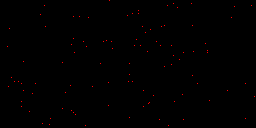


------
for feature x1 at shape (1, 64, 128, 16)
is_equal = False

------
for feature x2 at shape (1, 32, 64, 24)
is_equal = False

------
for feature x3 at shape (1, 16, 32, 24)
is_equal = True

------
for feature o0 at shape (1, 8, 16, 32)
is_equal = True

------
for feature o1 at shape (1, 16, 32, 24)
is_equal = True

------
for feature o2 at shape (1, 32, 64, 24)
is_equal = False

------
for feature o3 at shape (1, 64, 128, 16)
is_equal = False

------
for feature o4 at shape (1, 128, 256, 16)
is_equal = False

**********************

**********************

Setting atol=1e-08, the results from TensorFlow and PyTorch are equal or not = False

------
for feature x0 at shape (1, 128, 256, 16)
is_equal = False
 feature x0: channl 0 has abs = 2.151479883139018e-08
PS: black means diff <= thred 1e-08, red means diff > thred 1e-08


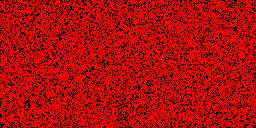


------
for feature x1 at shape (1, 64, 128, 16)
is_equal = False

------
for feature x2 at shape (1, 32, 64, 24)
is_equal = False

------
for feature x3 at shape (1, 16, 32, 24)
is_equal = False

------
for feature o0 at shape (1, 8, 16, 32)
is_equal = False

------
for feature o1 at shape (1, 16, 32, 24)
is_equal = False

------
for feature o2 at shape (1, 32, 64, 24)
is_equal = False

------
for feature o3 at shape (1, 64, 128, 16)
is_equal = False

------
for feature o4 at shape (1, 128, 256, 16)
is_equal = False


In [25]:
USING_FLOAT64 = False

if USING_FLOAT64:
  tf.keras.backend.set_floatx('float64')
  torch.set_default_dtype(torch.float64)
  DATA_TYPE = np.float64
else:
  tf.keras.backend.set_floatx('float32')
  torch.set_default_dtype(torch.float32)
  DATA_TYPE = np.float32

height = 128
width = 256

#prepare inputs and do inference
x = np.random.rand(1, 3, height, width).astype(DATA_TYPE)
x_tf = np.transpose(x, (0, 2, 3, 1)).astype(DATA_TYPE)

""" # TF feature """
feature_extractor = FeatureExtractor(num_feature)
lf = feature_extractor(x_tf)

""" # PT code """
torch.set_printoptions(precision=8)
feature_extractor_pt = FeatureExtractor_PT(num_feature)

x_pt = torch.from_numpy(x)
lf_pt = feature_extractor_pt(x_pt)

conv0 = getattr(feature_extractor_pt, 'down_0')
print (f"\nPyTorch ... conv0.weight.dtype = {conv0.weight.dtype}, conv0.bias.dtype={conv0.bias.dtype}\n")

ckpt = feature_extractor_pt.state_dict()
# Fetch weight from torch model by reading memory data
torch_weights = {k: v.numpy() for k, v in ckpt.items()}

if 1:
    n1 = 0
    for k,v in torch_weights.items():
        print (f"idx={n1}, torch, {k} ==> ({v.dtype}, {v.shape})")
        n1 += 1

    n2 = 0
    print ("\n\n")
    for w in feature_extractor.weights:
        print (f"idx={n2} ==> tensorflow, {w.name}: ({w.dtype}, {w.shape})")
        n2 += 1
    print (f"n1={n1}, n2={n2}")

keras_weights = []
for i, (k,v) in enumerate(torch_weights.items()):
    if k.endswith('.weight'):
        ## conv2d layer: Torch (out,in,h,w) vs Keras (h,w,in,out)
        w = np.transpose(v, (2,3,1,0))
    elif k.endswith('.bias'):
        w = v
    #keras_weights.append(np.ascontiguousarray(w))
    keras_weights.append(w)
    #if i <= 1:
    #  print (f"idx {i}, w = {w}")
    if 'init_layer_0.conv_em.bias' == k:
        # repeat the above two again for new self.conv_em_right in the TF model;
        w1 = np.transpose(
            torch_weights['init_layer_0.conv_em.weight'], (2,3,1,0)
            )
        b1 = torch_weights['init_layer_0.conv_em.bias']
        keras_weights.append(np.ascontiguousarray(w1))
        keras_weights.append(b1)

assert len(keras_weights) == len(feature_extractor.weights)

feature_extractor.set_weights(keras_weights)
lf2 = feature_extractor(x_tf)

# check the model weights
tf_weights_loaded = feature_extractor.get_weights()
for i, (k,v) in enumerate(torch_weights.items()):
  tf_w = tf_weights_loaded[i]
  ke_w = keras_weights[i]
  eql1 = np.allclose( tf_w, ke_w)
  if k.endswith('.weight'):
    ## conv2d layer: Torch (out,in,h,w) vs Keras (h,w,in,out)
    pt_w = np.transpose(v, (2,3,1,0))
  elif k.endswith('.bias'):
    pt_w = v
  eql2 = np.allclose(tf_w, pt_w)
  print (f"idx {i}, dtype = {tf_w.dtype}, {pt_w.dtype}, equal or not = {eql1}, {eql2}")


""" check the output at differnt threshold """
is_verbose = False
for my_atol in [1e-6, 1e-07, 1e-8]:
    is_equal = all( np.allclose(lf2[k].numpy(), lf_pt[k].detach().numpy().transpose((0,2,3,1)), rtol=1e-05, atol=my_atol) for k in lf2.keys()
            )
    # Should print True if dictionaries are equal
    print ("\n**********************")
    print ("\n**********************")
    print (f"\nSetting atol={my_atol}, the results from TensorFlow and PyTorch are equal or not = {is_equal}")

    if not is_equal:
        for i, k in enumerate(lf2.keys()):
          tf_y = lf2[k].numpy()
          pt_y = lf_pt[k].detach().numpy()
          pt_y2 = np.transpose(pt_y, (0, 2, 3, 1))
          print ("\n------")
          print (f"for feature {k} at shape {tf_y.shape}")
          #tmp1 = np.array_equal(pt_y2, tf_y)
          tmp2 = np.allclose(pt_y2, tf_y, rtol=0, atol=my_atol)

          tf_y_small = tf_y[0,:5,:5,0]
          pt_y2_small = pt_y2[0,:5,:5,0]
          print (f"is_equal = {tmp2}")
          if is_verbose:
            print (f"is_equal = {tmp2}, \n tf = \n{tf_y_small}, \n pt = \n{pt_y2_small}, \n diff = \n{np.abs(tf_y_small - pt_y2_small)}")
          if k == 'x0':
            #print ("tf_y = \n", tf_y[0,:10,:10,0])
            #print ("pt_y = \n", pt_y2[0,:10,:10,0])
            #for j in range(0,tf_y.shape[-1],2):
            for j in range(0,1):
              tmp_abs = np.abs(tf_y[0,:,:,j] - pt_y2[0,:,:,j])
              print (f" feature {k}: channl {j} has abs = {tmp_abs.mean()}")
              res = np.zeros((tf_y.shape[1], tf_y.shape[2], 3))
              res[tmp_abs <= my_atol] = (0, 0, 0) # black
              res[tmp_abs > my_atol] = (0, 0, 255) #red
              print (f"PS: black means diff <= thred {my_atol}, red means diff > thred {my_atol}")
              cv2_imshow(res.astype(np.uint8))
            #sys.exit()


We can see the results are always the same when using `float64` no matter what the tolerance `atol` is used in the fucntion `np.allclose`. But for `float32`, small tolerance `atol` will result in `Not Equal`.
- `Setting atol=1e-06, the results from TensorFlow and PyTorch are equal or not = True`
- `Setting atol=1e-07, the results from TensorFlow and PyTorch are equal or not = False`
- `Setting atol=1e-08, the results from TensorFlow and PyTorch are equal or not = False`